# Project: Investigate FBI gun data and its correlation to state demographics

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>


<a id='intro'></a>
## Introduction

In this report I'll be analyzing data from the FBI's National Instant Criminal Background Check System (NICS) - original source on [github](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md). Before a gun sale is completed, the cashier calls into this sytem to make sure the customer is eligible to buy a firearm based on a background check. NICS provides data on the number of firearm checks by month, state, and type. Although these data represent the number of background checks called in and not the actual number of guns sold, [The Trace](https://www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/) states that "the FBI’s NICS numbers are widely accepted as the best proxy for total gun sales in a given time period." It's important to note that these data do not include private gun sales, many of which do not require a background check.  

In addition to the NICS dataset, I'll be working with U.S. Census data from [census.gov](https://www.census.gov/) that includes information about state demographics. Most of the variables only have a data point from one year but some have data points from multiple years. Lastly, since this dataset only includes population data from 2010 and 2016, I will also be working with an additional dataset collected from census.gov that lists the U.S. population per year. I found the data [here](http://www.multpl.com/united-states-population/table).

**I will be exploring the following questions:**

What states have the most gun checks and least gun checks per capita in 2016 (for handguns and long guns)? What are the census characteristics associated with these states?

Which states have had the largest changes in handgun checks and long gun checks between 2010 and 2016?

What is the overall trend in U.S. handgun checks and long gun checks over the years?

**Time to explore!**

In [84]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# magic word to see plots inline with the notebook
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

First, I'll take a look at the **gun data** to see what I'll be working with.

In [85]:
# load first dataset and print out a few lines to inspect data
gun_df = pd.read_csv('gun_data.csv')
gun_df.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


One of the first things I notice is that 'month' is listed as year and month. In the Data Cleaning section, I will want to split this into two separate columns of 'year' and 'month' in order to be able to group by year.

In [86]:
## this displays a concise summary of the dataframe,
# including the number of non-null values in each column
# as well as the datatype for each column

gun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other   

There are many columns that I am not interested in for this analysis. I will drop those columns now before moving forward. The columns I am interested in are: month, state, handgun, long_gun. It looks like I do not need to change their respective datatypes.

Out of the columns I'm interested in, the 'handgun' and 'long_gun' columns both contain null values since their number of non-null values is less than the total number of entries (12485). I'll deal with these null values in the Data Cleaning section.

In [87]:
# keep only the columns of interest
gun_df = gun_df[['month', 'state', 'handgun', 'long_gun']]

# confirm
gun_df.head()

,month,state,handgun,long_gun
0,2017-09,Alabama,5734.0,6320.0
1,2017-09,Alaska,2320.0,2930.0
2,2017-09,Arizona,11063.0,7946.0
3,2017-09,Arkansas,4347.0,6063.0
4,2017-09,California,37165.0,24581.0


In [88]:
# check to see if there are any duplicated data
sum(gun_df.duplicated())

0

There are no duplicate rows in in this dataset.

Now, I'll take a look at the **U.S. Census Data**. After briefly viewing the data in Excel, I decided that I want to transpose the data so that the demographic variables are the column names. This will make it easier to work with the data.

However, first I want to inspect the data to find out what columns and rows I'm interested in keeping.

In [89]:
# load census data
census_df = pd.read_csv('US_Census_Data.csv', header = None)

# inspect the data to see what rows/columns to drop
census_df


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
2,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
3,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
4,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
5,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%
6,"Persons under 5 years, percent, April 1, 2010",NaN,6.40%,7.60%,7.10%,6.80%,6.80%,6.80%,5.70%,6.20%,...,0.073,0.064,7.70%,9.50%,5.10%,6.40%,6.50%,5.60%,6.30%,7.10%
7,"Persons under 18 years, percent, July 1, 2016,...",NaN,22.60%,25.20%,23.50%,23.60%,23.20%,22.80%,21.10%,21.50%,...,0.246,0.226,26.20%,30.20%,19.00%,22.20%,22.40%,20.50%,22.30%,23.70%
8,"Persons under 18 years, percent, April 1, 2010",NaN,23.70%,26.40%,25.50%,24.40%,25.00%,24.40%,22.90%,22.90%,...,0.249,0.236,27.30%,31.50%,20.70%,23.20%,23.50%,20.90%,23.60%,24.00%
9,"Persons 65 years and over, percent, July 1, 2...",NaN,16.10%,10.40%,16.90%,16.30%,13.60%,13.40%,16.10%,17.50%,...,0.16,0.157,12.00%,10.50%,18.10%,14.60%,14.80%,18.80%,16.10%,15.00%


I want to drop the 'Fact Note' column as well as several of the census variables (rows) I'm not interested in for this analysis. I also need to drop the end rows which appear to be footnotes.

I'll drop those columns and rows now before moving on.

In [90]:
# set list of desired rows
desired_rows = [0,1,4,14,15,16,17,19,20,21,63]

# keep only the desired rows in the data set
census_df = census_df.iloc[desired_rows]

# drop the 'Fact note' column
census_df = census_df.drop(columns = [1])

# confirm dataset
census_df

,0,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,51
0,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1,"Population estimates, July 1, 2016, (V2016)","4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065","20,612,439",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
4,"Population, Census, April 1, 2010","4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934","18,801,310",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
14,"Black or African American alone, percent, July...",26.80%,3.80%,4.90%,15.70%,6.50%,4.50%,11.80%,22.60%,16.80%,...,0.02,0.171,12.60%,1.40%,1.30%,19.80%,4.10%,3.60%,6.60%,1.30%
15,"American Indian and Alaska Native alone, perce...",0.70%,15.20%,5.40%,1.00%,1.70%,1.60%,0.50%,0.60%,0.50%,...,0.09,0.004,1.00%,1.60%,0.40%,0.50%,1.90%,0.20%,1.10%,2.70%
16,"Asian alone, percent, July 1, 2016, (V2016)",1.40%,6.30%,3.40%,1.60%,14.80%,3.30%,4.70%,4.00%,2.90%,...,0.015,0.018,4.80%,2.50%,1.80%,6.60%,8.60%,0.80%,2.80%,1.00%
17,Native Hawaiian and Other Pacific Islander alo...,0.10%,1.30%,0.30%,0.30%,0.50%,0.20%,0.10%,0.10%,0.10%,...,0.001,0.001,0.10%,1.00%,Z,0.10%,0.80%,Z,0.10%,0.10%
19,"Hispanic or Latino, percent, July 1, 2016, (V...",4.20%,7.00%,30.90%,7.30%,38.90%,21.30%,15.70%,9.20%,24.90%,...,0.037,0.052,39.10%,13.80%,1.90%,9.10%,12.40%,1.50%,6.70%,10.00%
20,"White alone, not Hispanic or Latino, percent, ...",65.80%,61.20%,55.50%,72.90%,37.70%,68.60%,67.70%,62.90%,54.90%,...,0.825,0.742,42.60%,78.80%,93.10%,62.40%,69.50%,92.30%,81.70%,84.10%
21,"Veterans, 2011-2015","363,170","69,323","505,794","220,953","1,777,410","391,725","199,331","71,213","1,507,738",...,63742,462414,"1,539,655","134,332","44,708","706,539","564,864","150,021","381,940","48,505"


From this inspection, I can see that some of the values in the '%' categories are shown as decimals instead of percentages. I will make sure these values are multiplied by 100 during the data cleaning steps.

Now I'm ready to transpose the data.

In [91]:
# transpose the dataframe
census_df = census_df.transpose()
census_df = census_df.reset_index(drop=True)

# confirm
census_df.head()


,0,1,4,14,15,16,17,19,20,21,63
0,Fact,"Population estimates, July 1, 2016, (V2016)","Population, Census, April 1, 2010","Black or African American alone, percent, July...","American Indian and Alaska Native alone, perce...","Asian alone, percent, July 1, 2016, (V2016)",Native Hawaiian and Other Pacific Islander alo...,"Hispanic or Latino, percent, July 1, 2016, (V...","White alone, not Hispanic or Latino, percent, ...","Veterans, 2011-2015","Population per square mile, 2010"
1,Alabama,"4,863,300","4,779,736",26.80%,0.70%,1.40%,0.10%,4.20%,65.80%,"363,170",94.4
2,Alaska,"741,894","710,231",3.80%,15.20%,6.30%,1.30%,7.00%,61.20%,"69,323",1.2
3,Arizona,"6,931,071","6,392,017",4.90%,5.40%,3.40%,0.30%,30.90%,55.50%,"505,794",56.3
4,Arkansas,"2,988,248","2,915,918",15.70%,1.00%,1.60%,0.30%,7.30%,72.90%,"220,953",56


Now I want to set the values in row 0 as the column names.

In [92]:
# set names in row 0 as column names
census_df.columns = census_df.iloc[0]

# drop row 0
census_df = census_df.drop(0)

# confirm
census_df.head()

,Fact,"Population estimates, July 1, 2016, (V2016)","Population, Census, April 1, 2010","Black or African American alone, percent, July 1, 2016, (V2016)","American Indian and Alaska Native alone, percent, July 1, 2016, (V2016)","Asian alone, percent, July 1, 2016, (V2016)","Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016, (V2016)","Hispanic or Latino, percent, July 1, 2016, (V2016)","White alone, not Hispanic or Latino, percent, July 1, 2016, (V2016)","Veterans, 2011-2015","Population per square mile, 2010"
1,Alabama,"4,863,300","4,779,736",26.80%,0.70%,1.40%,0.10%,4.20%,65.80%,"363,170",94.4
2,Alaska,"741,894","710,231",3.80%,15.20%,6.30%,1.30%,7.00%,61.20%,"69,323",1.2
3,Arizona,"6,931,071","6,392,017",4.90%,5.40%,3.40%,0.30%,30.90%,55.50%,"505,794",56.3
4,Arkansas,"2,988,248","2,915,918",15.70%,1.00%,1.60%,0.30%,7.30%,72.90%,"220,953",56
5,California,"39,250,017","37,253,956",6.50%,1.70%,14.80%,0.50%,38.90%,37.70%,"1,777,410",239.1


In the Data Cleaning section, I will rename the columns to be a bit simpler, and the 'Fact' column will be renamed to 'State'.

To continue initial inspection, I will check for duplicate rows, look at the datatypes, and check to see if there are null values.

In [93]:
# check for duplicate rows.
sum(census_df.duplicated())

0

In [94]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 11 columns):
Fact                                                                                 50 non-null object
Population estimates, July 1, 2016,  (V2016)                                         50 non-null object
Population, Census, April 1, 2010                                                    50 non-null object
Black or African American alone, percent, July 1, 2016,  (V2016)                     50 non-null object
American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)             50 non-null object
Asian alone, percent, July 1, 2016,  (V2016)                                         50 non-null object
Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)    50 non-null object
Hispanic or Latino, percent, July 1, 2016,  (V2016)                                  50 non-null object
White alone, not Hispanic or Latino, percent, July 1, 2016,  (V20

Based on this information, I will change the population columns to floats. I will also change all the percentages to floats and make sure that they are all represented as percentages (i.e. multipled by 100 if shown as a decimal). I'll make these changes in the next section

There are no null values so no cleaning needs to be done regarding null values in this dataframe.

Lastly, I will take a look at the final dataset of **U.S. population by year**.

In [95]:
# load census data
population_df = pd.read_csv('US_population_by_year.csv')

# inspect the data
population_df.head()

,Date,Value
0,1-Jan-18,326.97 million
1,1-Jul-17,325.72 million
2,1-Jul-16,323.41 million
3,1-Jul-15,321.04 million
4,1-Jul-14,318.62 million


Now I'll check datatypes.

In [96]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 2 columns):
Date     119 non-null object
Value    119 non-null object
dtypes: object(2)
memory usage: 1.9+ KB


In the data cleaning steps, I will change the 'Date' column to the datetime datatype so that I can parse the year (I'm only interested in the year). I will also change the 'Value' data points to floats after removing the string 'million'. There are no null values so I won't have to worry about those.

Lastly, I'll make sure there are no duplicate data points.

In [97]:
sum(population_df.duplicated())

0

There are no duplicate rows.

Now that I've inspected each dataset, I'll move on to the Data Cleaning steps.


### Data Cleaning

First I'll clean up the **gun data**. I'll start by splitting the 'month' column into 'month' and 'year' so that I can group by year.

In [98]:
# split month column into year and month columns
gun_df['year'] = gun_df['month'].apply(lambda x: x.split("-")[0])
gun_df['month'] = gun_df['month'].apply(lambda x: x.split("-")[1])

# confirm
gun_df.head()


,month,state,handgun,long_gun,year
0,09,Alabama,5734.0,6320.0,2017
1,09,Alaska,2320.0,2930.0,2017
2,09,Arizona,11063.0,7946.0,2017
3,09,Arkansas,4347.0,6063.0,2017
4,09,California,37165.0,24581.0,2017


Now I want to check to see what rows have null values since I know there are some null values in the handgun and long_gun columns.

In [99]:
# select only rows with null values
null_values = gun_df[gun_df.isnull().any(axis=1)]

# display null values
null_values

,month,state,handgun,long_gun,year
7914,10,Virgin Islands,NaN,NaN,2005
7969,09,Virgin Islands,NaN,NaN,2005
8024,08,Virgin Islands,NaN,NaN,2005
8079,07,Virgin Islands,NaN,NaN,2005
8134,06,Virgin Islands,NaN,NaN,2005
8189,05,Virgin Islands,NaN,NaN,2005
8244,04,Virgin Islands,NaN,1.0,2005
8299,03,Virgin Islands,NaN,NaN,2005
8354,02,Virgin Islands,NaN,NaN,2005
8409,01,Virgin Islands,NaN,NaN,2005


It turns out the state names in this list of rows are not in the census data. I can just drop the rows with states that are not in the census data and therefore will not need to deal with any null values.

In [100]:
# convert column of states in census data into a list to check against gun data
# NOTE: the column header for the state names is still named 'Fact'
census_states = census_df['Fact'].tolist()

# drop states that aren't in census data
for index, row in gun_df.iterrows():
    if row['state'] not in census_states:
        gun_df.drop(index, inplace=True)

In [101]:
# confirm
gun_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350 entries, 0 to 12484
Data columns (total 5 columns):
month       11350 non-null object
state       11350 non-null object
handgun     11350 non-null float64
long_gun    11350 non-null float64
year        11350 non-null object
dtypes: float64(2), object(3)
memory usage: 532.0+ KB


There are now no null values, and the number of entries has gone down as aspected. 

Next, I want to take a quick look at descriptive statistics to make sure the results make sense.

In [102]:
#Look at descriptive statistics
gun_df.describe()

,handgun,long_gun
count,11350.000000,11350.000000
mean,6509.303877,8575.439648
std,8829.284061,9416.217660
min,0.000000,0.000000
25%,1327.250000,2778.000000
50%,3622.500000,5893.000000
75%,7987.750000,11021.500000
max,107224.000000,108058.000000


Nothing is raising a flag here so I'll move on. Since data types are already as I want them, I will move on to cleaning up the **census data**.

First, I want to change the names of the columns.

In [103]:
# list new column names
col_labels = ['State', 'Population 2016', 'Population 2010', '% Black or African American', '% American Indian and Alaska Native', '% Asian','% Hawaiian and Pacific Islander', '% Hispanic or Latino', '% White, not Hispanic or Latino', 'Veterans', 'Population per square mile 2010']

# set list as new names for the columns
census_df.columns = col_labels

census_df.head()

,State,Population 2016,Population 2010,% Black or African American,% American Indian and Alaska Native,% Asian,% Hawaiian and Pacific Islander,% Hispanic or Latino,"% White, not Hispanic or Latino",Veterans,Population per square mile 2010
1,Alabama,"4,863,300","4,779,736",26.80%,0.70%,1.40%,0.10%,4.20%,65.80%,"363,170",94.4
2,Alaska,"741,894","710,231",3.80%,15.20%,6.30%,1.30%,7.00%,61.20%,"69,323",1.2
3,Arizona,"6,931,071","6,392,017",4.90%,5.40%,3.40%,0.30%,30.90%,55.50%,"505,794",56.3
4,Arkansas,"2,988,248","2,915,918",15.70%,1.00%,1.60%,0.30%,7.30%,72.90%,"220,953",56
5,California,"39,250,017","37,253,956",6.50%,1.70%,14.80%,0.50%,38.90%,37.70%,"1,777,410",239.1


Now I will make sure all the values in the columns with percentages are represented as percentages and not decimals.  I noticed that some were represented as decimals in the previous section.

When I first ran the code to do this (two cells down), I got an error saying 'could not convert string to float: 'Z''. According to the original footnotes of the csv file, 'Z' means:

        Value greater than zero but less than half unit of measure shown. 

Therefore, I'll first replace the Z's with zeroes and then run the code to change the decimals to percentages.


In [104]:
# change Z values to 0
for c in col_labels:
    census_df[c] = census_df[c].apply(lambda x: '0' if x=='Z' else x)


In [105]:
percent_columns = ['% Black or African American', '% American Indian and Alaska Native', '% Asian','% Hawaiian and Pacific Islander', '% Hispanic or Latino', '% White, not Hispanic or Latino']

# multiply by 100 to change to percentage if '%' not in value
for c in percent_columns:
        census_df[c] = census_df[c].apply(lambda x: str(float(x)*100) if '%' not in x else x)


Now I want to change the datatype of all columns other than 'State' to float

In [106]:
# for populations, remove the comma before converting to float
census_df['Population 2016'] = census_df['Population 2016'].str.replace(',','').astype('float64')
census_df['Population 2010'] = census_df['Population 2010'].str.replace(',','').astype('float64')
census_df['Veterans'] = census_df['Veterans'].str.replace(',','').astype('float64')
census_df['Population per square mile 2010'] = census_df['Population per square mile 2010'].str.replace(',','').astype('float64')


For the percentage columns, I know that most of the values have a percent sign in front. So first I will need to remove the percent signs from those values and then convert all the values to floats.

In [107]:
# remove percent signs and then convert all values to floats
for c in percent_columns:
    census_df[c] = census_df[c].apply(lambda x: float(x.replace('%', '')) if '%' in x else float(x))


In [108]:
# confirm changes
census_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 11 columns):
State                                  50 non-null object
Population 2016                        50 non-null float64
Population 2010                        50 non-null float64
% Black or African American            50 non-null float64
% American Indian and Alaska Native    50 non-null float64
% Asian                                50 non-null float64
% Hawaiian and Pacific Islander        50 non-null float64
% Hispanic or Latino                   50 non-null float64
% White, not Hispanic or Latino        50 non-null float64
Veterans                               50 non-null float64
Population per square mile 2010        50 non-null float64
dtypes: float64(10), object(1)
memory usage: 4.7+ KB


Everything looks as I want it to now. Now I'll take a look at the descriptive statistics to make sure they make sense.

In [109]:
# look at descriptive statistics to make sure they make sense
census_df.describe()

,Population 2016,Population 2010,% Black or African American,% American Indian and Alaska Native,% Asian,% Hawaiian and Pacific Islander,% Hispanic or Latino,"% White, not Hispanic or Latino",Veterans,Population per square mile 2010
count,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,5.000000e+01,50.000000
mean,6.448927e+06,6.162876e+06,11.024000,1.998000,4.342000,0.39600,11.714000,69.320000,4.015940e+05,194.962000
std,7.271769e+06,6.848235e+06,9.631868,3.065109,5.561973,1.43768,10.325993,15.663463,3.831585e+05,261.091465
min,5.855010e+05,5.636260e+05,0.600000,0.200000,0.800000,0.00000,1.500000,22.100000,4.470800e+04,1.200000
25%,1.850106e+06,1.833004e+06,3.625000,0.500000,1.725000,0.10000,5.000000,59.550000,1.332715e+05,44.450000
50%,4.559320e+06,4.436370e+06,8.200000,0.750000,2.850000,0.10000,9.200000,72.950000,3.020175e+05,98.750000
75%,7.198768e+06,6.680312e+06,15.525000,1.600000,4.775000,0.20000,13.550000,80.375000,4.949490e+05,209.500000
max,3.925002e+07,3.725396e+07,37.700000,15.200000,37.700000,10.20000,48.500000,93.500000,1.777410e+06,1195.500000


All seems to look good.

Finally, I'll clean up the **U.S. population** dataset.
I'll first delete 'million' from each data point in the 'Value' column and then convert them to floats.

In [110]:
# delete 'million' from value string and change to float
population_df['Value'] = population_df['Value'].str.replace(' million','').astype(float)

I then want to parse the year from the 'Date' column but first I need to change the data to datetime type. I'll then change it back to a string after parsing just the year.

In [111]:
# change date to datetime type, then parse the year and convert to string

population_df['Date'] = pd.to_datetime(population_df['Date']).dt.year.astype(str)

Lastly, I want to rename the columns so that they make more sense.

In [112]:
population_df.columns = ['Year', 'Population (millions)']

In [113]:
# confirm changes
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 2 columns):
Year                     119 non-null object
Population (millions)    119 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [114]:
# further confirm changes
population_df.head()

,Year,Population (millions)
0,2018,326.97
1,2017,325.72
2,2016,323.41
3,2015,321.04
4,2014,318.62


Everything looks good now. I'm now ready to move on to Exploratory Data Analysis.

<a id='eda'></a>
## Exploratory Data Analysis


### What states have the most gun checks and least gun checks per capita in 2016? What are the census characteristics associated with these states?

The first thing I need to do to get gun totals per capita is to divide the gun values by each state's population in 2016.

In [115]:
# convert the population columns from census_df into a list
pop_list_2016 = census_df['Population 2016'].tolist()

In [116]:
# pull only the 2016 data from gun_df
gun_2016_df = gun_df.loc[gun_df['year'] == '2016']

Now that I have a dataframe with just the 2016 gun data, I'm interested in looking at the total gun checks per state so I need to group by state and get the sum.

In [117]:
# group by state and get the sum for each state in 2016
gun_totals_2016 = gun_2016_df.groupby('state').sum()

# reset index to convert groupby object back to dataframe
gun_totals_2016_df = gun_totals_2016.reset_index()
gun_totals_2016_df.head()

,state,handgun,long_gun
0,Alabama,153123.0,121963.0
1,Alaska,37491.0,36887.0
2,Arizona,166784.0,108988.0
3,Arkansas,80244.0,82120.0
4,California,560355.0,554550.0


Now I'm ready to normalize the values to population.

In [118]:
# This function takes in 3 inputs: a list of populations, a dataframe, and a list of columns in that dataframe.
# It divides the values in those columns by the respective population and then returns the modified dataframe.

def normalize_to_pop(populations, df, columns):
    for index, pop in enumerate(populations):
        for c in columns:
            df[c].iloc[index] = df[c].iloc[index]/pop
    return df

In [119]:
# list of columns that need normalized
columns = ['handgun', 'long_gun']

# normalization function
normalize_to_pop(pop_list_2016, gun_totals_2016_df, columns)

# check to confirm
gun_totals_2016_df.head()

/Users/cadpav/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,state,handgun,long_gun
0,Alabama,0.031485,0.025078
1,Alaska,0.050534,0.049720
2,Arizona,0.024063,0.015725
3,Arkansas,0.026853,0.027481
4,California,0.014277,0.014129


Before I move on, I also want to normalize the number of veterans in the census data to the state populations as well, to get veterans per capita.

In [120]:
column = ['Veterans']
normalize_to_pop(pop_list_2016, census_df, column)
    
# check to confirm
census_df.head()

/Users/cadpav/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,State,Population 2016,Population 2010,% Black or African American,% American Indian and Alaska Native,% Asian,% Hawaiian and Pacific Islander,% Hispanic or Latino,"% White, not Hispanic or Latino",Veterans,Population per square mile 2010
1,Alabama,4863300.0,4779736.0,26.8,0.7,1.4,0.1,4.2,65.8,0.074676,94.4
2,Alaska,741894.0,710231.0,3.8,15.2,6.3,1.3,7.0,61.2,0.093441,1.2
3,Arizona,6931071.0,6392017.0,4.9,5.4,3.4,0.3,30.9,55.5,0.072975,56.3
4,Arkansas,2988248.0,2915918.0,15.7,1.0,1.6,0.3,7.3,72.9,0.073941,56.0
5,California,39250017.0,37253956.0,6.5,1.7,14.8,0.5,38.9,37.7,0.045284,239.1


Now I'm ready to plot the 2016 gun totals per capita of all 50 states. I'll break it down by gun type and sort from highest to lowest gun totals to see the states with the highest and lowest gun totals for 2016.

I'll start with handgun totals.

In [121]:
import seaborn as sns
sns.set_style('darkgrid')

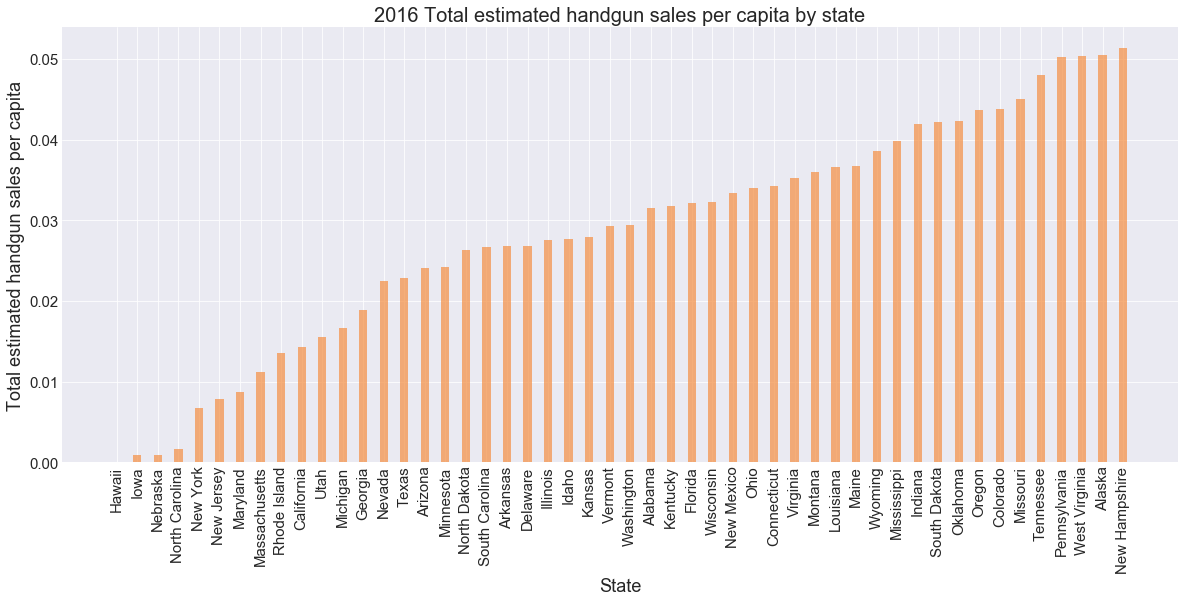

In [122]:
# Plot handgun totals of all 50 states

# Sort dataframe in order from lowest to highest
key_hg = gun_totals_2016_df['handgun']
sorted_gun_totals_2016_df = gun_totals_2016_df.iloc[key_hg.argsort()]

# set plot characteristics
labels = sorted_gun_totals_2016_df['state'].tolist()
locations = range(1,51)
handgun_heights_2016 = sorted_gun_totals_2016_df['handgun'].tolist()

plt.figure(figsize=(20, 8))  # width:20, height:8
plt.bar(locations, handgun_heights_2016, align='center', width=0.4, color='#f48e41', alpha=0.7)
plt.xticks(locations, labels, rotation='vertical' )

plt.title('2016 Total estimated handgun sales per capita by state', size = 20)
plt.xlabel('State', size = 18)
plt.ylabel('Total estimated handgun sales per capita', size = 18)
plt.xticks(size=15)
plt.yticks(size=15);

From this graph, it's clear that the five states with the highest handgun checks per capita are New Hampshire, Alaska, West Virginia, Pennsylvania, and Tennessee. The five states with the lowest handgun checks per capita are Hawaii, Iowa, North Carolina, New York, and New Jersey.

Let's see how the census characteristics of the highest states compare with those of the lowest states. I'll do this by finding the mean values of the census variables for the high group and the low group.


In [123]:
# create subset census dataframes with just the highest states and the lowest states

highest_hg_states = ['New Hampshire', 'Alaska', 'West Virginia', 'Pennsylvania', 'Tennessee']
lowest_hg_states = ['Hawaii', 'Iowa', 'North Carolina', 'New York', 'New Jersey']

high_handgun_census = census_df.loc[census_df['State'].apply(lambda x: x in highest_hg_states)]
low_handgun_census = census_df.loc[census_df['State'].apply(lambda x: x in lowest_hg_states)]

# check to confirm
low_handgun_census

,State,Population 2016,Population 2010,% Black or African American,% American Indian and Alaska Native,% Asian,% Hawaiian and Pacific Islander,% Hispanic or Latino,"% White, not Hispanic or Latino",Veterans,Population per square mile 2010
11,Hawaii,1428557.0,1360301.0,2.2,0.4,37.7,10.2,10.4,22.1,0.077167,211.8
15,Iowa,3134693.0,3046355.0,3.7,0.5,2.5,0.1,5.8,86.2,0.067332,54.5
30,New Jersey,8944469.0,8791894.0,15.0,0.6,9.8,0.1,20.0,55.8,0.043969,1195.5
32,New York,19745289.0,19378102.0,17.7,1.0,8.9,0.1,19.0,55.8,0.041964,411.2
33,North Carolina,10146788.0,9535483.0,22.2,1.6,2.9,0.1,9.2,63.5,0.068605,196.1


Now I'll look at the means for the top 5 states and the lowest 5 states using these two new data subsets.

In [124]:
# get means for states with highest gun totals
high_hg_means = high_handgun_census.mean().reset_index() # reset_index turns data object into standard dataframe
high_hg_means.columns = ['Category', 'Mean']
high_hg_means

,Category,Mean
0,Population 2016,4.668642e+06
1,Population 2010,4.585636e+06
2,% Black or African American,7.560000e+00
3,% American Indian and Alaska Native,3.300000e+00
4,% Asian,3.020000e+00
5,% Hawaiian and Pacific Islander,3.200000e-01
6,% Hispanic or Latino,4.840000e+00
7,"% White, not Hispanic or Latino",7.910000e+01
8,Veterans,7.860775e-02
9,Population per square mile 2010,1.326200e+02


In [125]:
# get means for states with lowest gun totals
low_hg_means = low_handgun_census.mean().reset_index()
low_hg_means.columns = ['Category', 'Mean']
low_hg_means

,Category,Mean
0,Population 2016,8.679959e+06
1,Population 2010,8.422427e+06
2,% Black or African American,1.216000e+01
3,% American Indian and Alaska Native,8.200000e-01
4,% Asian,1.236000e+01
5,% Hawaiian and Pacific Islander,2.120000e+00
6,% Hispanic or Latino,1.288000e+01
7,"% White, not Hispanic or Latino",5.668000e+01
8,Veterans,5.980740e-02
9,Population per square mile 2010,4.138200e+02


Before I plot the data, I'll do the same steps to look at long gun data. I'll then plot census variables for the long gun and hand gun data on the same graphs to visualize the differences between the highest gun check states and the lowest gun check states.

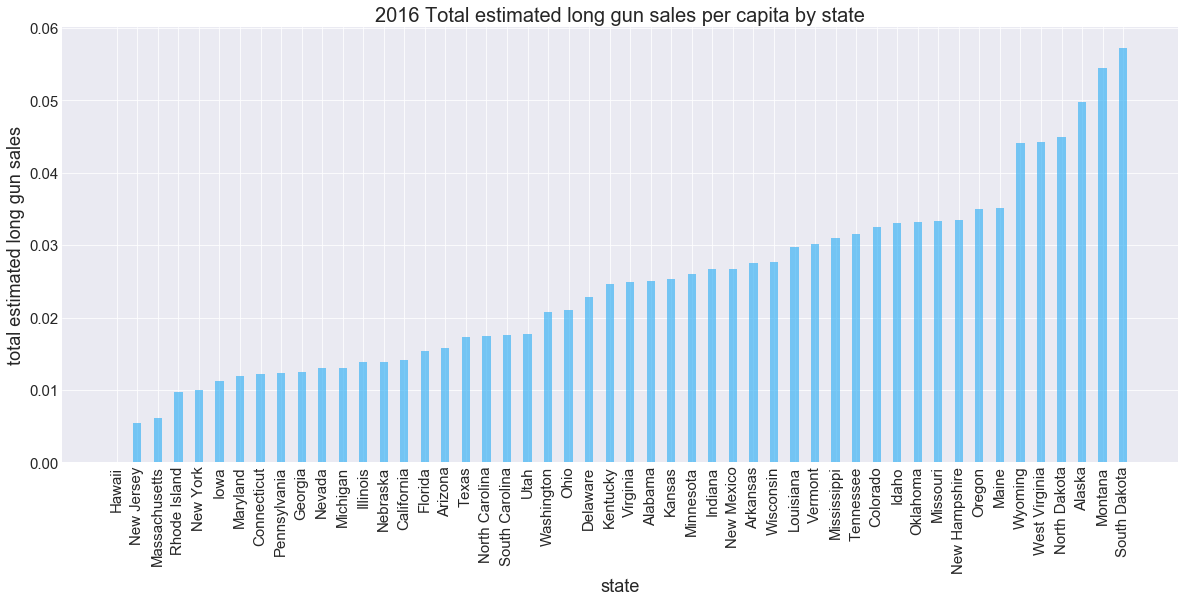

In [126]:
#Plot long gun totals of all 50 states

#Sort dataframe in order from lowest to highest sales
key_lg = gun_totals_2016_df['long_gun']
sorted_gun_totals_2016_df = gun_totals_2016_df.iloc[key_lg.argsort()]

labels = sorted_gun_totals_2016_df['state'].tolist()
locations = range(1,51)
longgun_heights_2016 = sorted_gun_totals_2016_df['long_gun'].tolist()

plt.figure(figsize=(20, 8))  # width:20, height:8
plt.bar(locations, longgun_heights_2016, align='center', width=0.4, color='#41b5f4', alpha=0.7)
plt.xticks(locations, labels, rotation='vertical' )

plt.title('2016 Total estimated long gun sales per capita by state', size=20)
plt.xlabel('state', size=18)
plt.ylabel('total estimated long gun sales', size=18)
plt.xticks(size=15)
plt.yticks(size=15);

The five states with the highest long gun checks per capita are South Dakota, Montana, Alaska, North Dakota, and West Virginia. The five states with the lowest long gun checks per capita are Hawaii, New Jersey, Massachussetts, Rhode Island, and New York.

Let's see how the census characteristics of the highest states compare with those of the lowest states. I'll do this by finding the mean values of the census variables for the high group and the low group, just as I did for the handgun data.

In [127]:
# create  subset census dataframes with just the highest states and the lowest states

highest_lg_states = ['South Dakota', 'Montana', 'Alaska', 'North Dakota', 'West Virginia']
lowest_lg_states = ['Hawaii', 'New Jersey', 'Massachussetts', 'Rhode Island', 'New York']

high_longgun_census = census_df.loc[census_df['State'].apply(lambda x: x in highest_lg_states)]
low_longgun_census = census_df.loc[census_df['State'].apply(lambda x: x in lowest_lg_states)]

# check to confirm
high_longgun_census

,State,Population 2016,Population 2010,% Black or African American,% American Indian and Alaska Native,% Asian,% Hawaiian and Pacific Islander,% Hispanic or Latino,"% White, not Hispanic or Latino",Veterans,Population per square mile 2010
2,Alaska,741894.0,710231.0,3.8,15.2,6.3,1.3,7.0,61.2,0.093441,1.2
26,Montana,1042520.0,989415.0,0.6,6.6,0.8,0.1,3.6,86.5,0.086329,6.8
34,North Dakota,757952.0,672591.0,2.9,5.5,1.5,0.1,3.6,85.0,0.067523,9.7
41,South Dakota,865454.0,814180.0,2.0,9.0,1.5,0.1,3.7,82.5,0.073652,10.7
48,West Virginia,1831102.0,1852994.0,3.6,0.2,0.8,0.0,1.5,92.3,0.081929,77.1


In [128]:
# get means for states with highest long gun totals
high_lg_means = high_longgun_census.mean().reset_index() # reset_index turns data object into standard dataframe
high_lg_means.columns = ['Category', 'Mean']
high_lg_means

,Category,Mean
0,Population 2016,1.047784e+06
1,Population 2010,1.007882e+06
2,% Black or African American,2.580000e+00
3,% American Indian and Alaska Native,7.300000e+00
4,% Asian,2.180000e+00
5,% Hawaiian and Pacific Islander,3.200000e-01
6,% Hispanic or Latino,3.880000e+00
7,"% White, not Hispanic or Latino",8.150000e+01
8,Veterans,8.057469e-02
9,Population per square mile 2010,2.110000e+01


In [129]:
# get means for states with lowest long gun totals
low_lg_means = low_longgun_census.mean().reset_index() # reset_index turns data object into standard dataframe
low_lg_means.columns = ['Category', 'Mean']
low_lg_means

,Category,Mean
0,Population 2016,7.793685e+06
1,Population 2010,7.645716e+06
2,% Black or African American,1.075000e+01
3,% American Indian and Alaska Native,7.500000e-01
4,% Asian,1.500000e+01
5,% Hawaiian and Pacific Islander,2.650000e+00
6,% Hispanic or Latino,1.607500e+01
7,"% White, not Hispanic or Latino",5.175000e+01
8,Veterans,5.641165e-02
9,Population per square mile 2010,7.091500e+02


Now that I've gotten the mean values for the highest and lowest gun states for both handguns and long guns, I'm ready to visualize the data. First, I'll graph the census variables regarding race demographics.

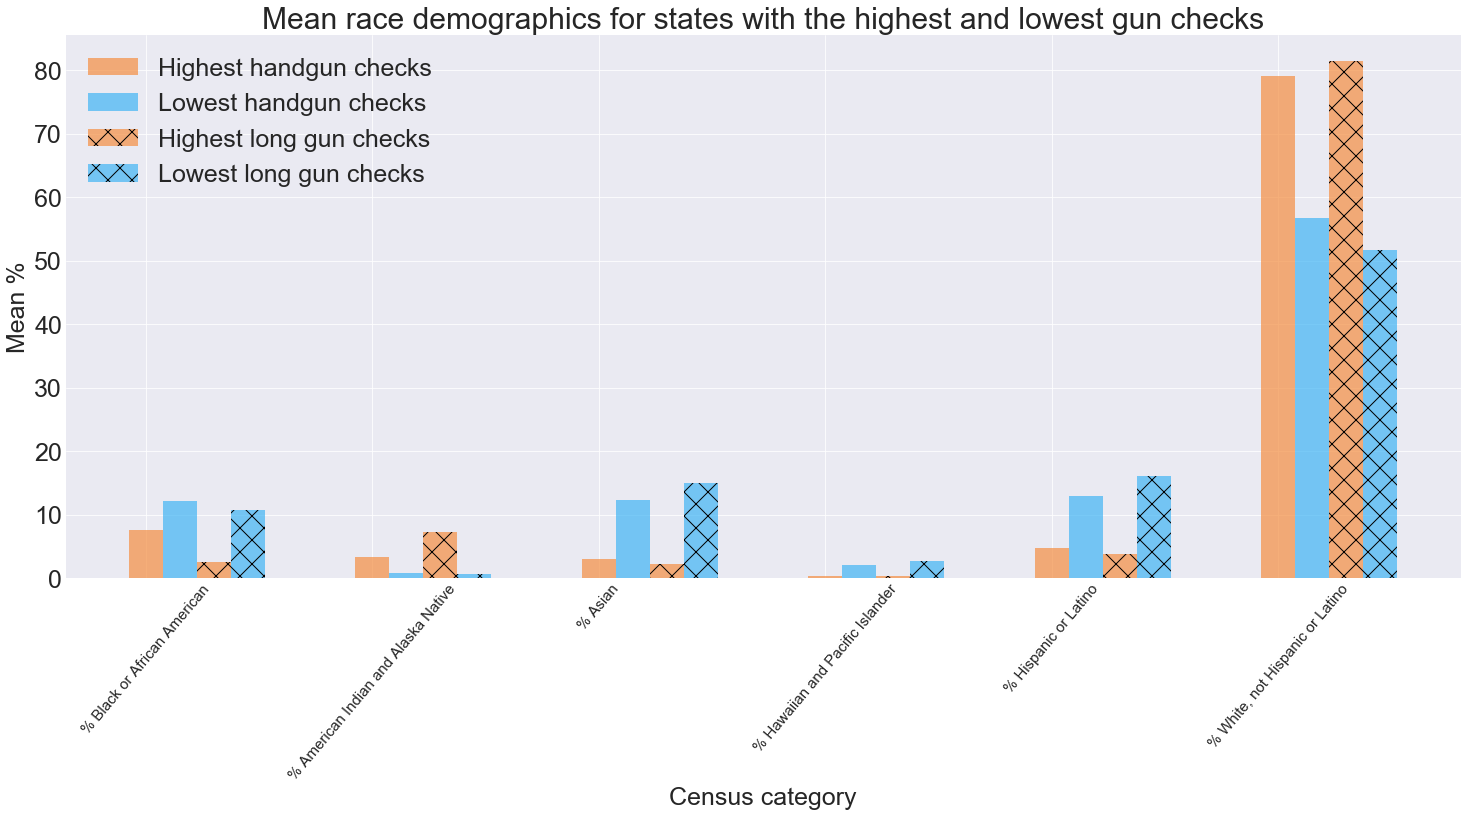

In [130]:
# choose only the race categories and set as labels
labels = high_hg_means['Category'][2:8].tolist()

# Set means as heights
high_hg_heights = high_hg_means['Mean'][2:8].tolist()
low_hg_heights = low_hg_means['Mean'][2:8].tolist()
high_lg_heights = high_lg_means['Mean'][2:8].tolist()
low_lg_heights = low_lg_means['Mean'][2:8].tolist()
    
ind = np.arange(len(labels)) # the x locations for the groups
width = 0.15 # the width of the bars

plt.figure(figsize=(25, 10))  # width:20, height:5

# plot bars for the handgun and long gun means
high_handgun_bars = plt.bar(ind, high_hg_heights, width, color='#f48e41', alpha=.7, label='Highest handgun checks')
low_handgun_bars = plt.bar(ind + width, low_hg_heights, width, color='#41b5f4', alpha=.7, label='Lowest handgun checks')
high_longgun_bars = plt.bar(ind + 2*width, high_lg_heights, width, color='#f48e41', hatch = 'x', alpha=.7, label='Highest long gun checks')
low_longgun_bars = plt.bar(ind + 3*width, low_lg_heights, width, color='#41b5f4', hatch = 'x', alpha=.7, label='Lowest long gun checks')

# title and labels
plt.ylabel('Mean %', size=25)
plt.xlabel('Census category', size=25)
plt.title('Mean race demographics for states with the highest and lowest gun checks', size=30)
locations = ind + width / 2  # xtick locations
plt.xticks(ind, labels, rotation=50, size=15)
plt.yticks(size=25)

# legend
plt.legend(loc=0, prop={'size': 25});

I can now visually see the comparisons between the highest gun states and the lowest gun states, but now I want to do a t-test to check to see if any of these differences are significant, within each gun type. I'll run the test on the high_handgun_census vs. low_handgun_census, and high_longgun_census vs. low_longgun_census dataframes instead of on the mean dataframes in order to have multiple datapoints for statistics. P values less than 0.05 are significant.

In [131]:
# define function to get p value from ttest between two dataframes

# This function takes in three inputs: a list of columns and two dataframes.
# It then runs a ttest between the two dataframes for the specified columns and prints out
# the column name and associated p-value.

def get_pvalues(columns, df1, df2):
    for c in columns:
        list1 = df1[c]
        list2 = df2[c]
        t, p = ttest_ind(list1,list2)
        print (c, p)


First I'll get the p-values for the handgun comparisons.

In [132]:
columns = percent_columns

get_pvalues(columns, high_handgun_census, low_handgun_census)

% Black or African American 0.37797928025517347
% American Indian and Alaska Native 0.429926745756256
% Asian 0.19328949863804665
% Hawaiian and Pacific Islander 0.40219277193525627
% Hispanic or Latino 0.02804851656527591
% White, not Hispanic or Latino 0.09349521362383638


Next, I'll get the p-values for the long gun comparisons.

In [133]:
get_pvalues(columns, high_longgun_census, low_longgun_census)

% Black or African American 0.03532957519161728
% American Indian and Alaska Native 0.050258093441191844
% Asian 0.10369833933790942
% Hawaiian and Pacific Islander 0.33042583916693413
% Hispanic or Latino 0.0007955809843142207
% White, not Hispanic or Latino 0.032387285145503535


Based on the graph, the highest handgun states have a lower percentage of Black/African Americans, Asians, Hawaiian/Pacific Islanders, and Hispanic/Latinos than the lowest handgun states, and a higher percentage of white demographic. This trend is the same for long guns as well. However, only some of these differences are significant (<0.05).

For handguns, the only significant difference based on p-value is the difference between the Hispanic/Latino percentage for high gun states vs. low gun states. For long guns, the differences between the highest states and lowest states were significant for the Black/African American percentage, Hispanic/Latino percentage, and white percentage.

Next, I'll plot the averages of population per square mile for the highest gun states and lowest gun states, for both handguns and long guns.

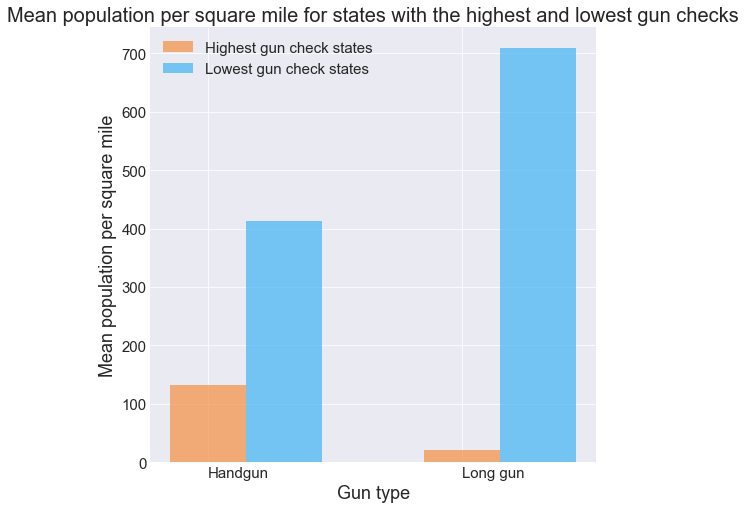

In [134]:
labels = ['Handgun', 'Long gun']

# Set means of 'population per square mile' columns as heights
high_hg_height = high_hg_means['Mean'][9]
low_hg_height = low_hg_means['Mean'][9]
high_lg_height = high_lg_means['Mean'][9]
low_lg_height = low_lg_means['Mean'][9]

high_means = [high_hg_height, high_lg_height]
low_means = [low_hg_height, low_lg_height]
    
ind = np.arange(len(labels)) # the x locations for the groups
width = 0.3 # the width of the bars

plt.figure(figsize=(8, 8))  # width:20, height:5

# plot bars
high_bars = plt.bar(ind, high_means, width, color='#f48e41', alpha=.7, label='Highest gun check states')
low_bars = plt.bar(ind + width, low_means, width, color='#41b5f4', alpha=.7, label='Lowest gun check states')

# title and labels
plt.ylabel('Mean population per square mile', size=18)
plt.xlabel('Gun type', size=18)
plt.title('Mean population per square mile for states with the highest and lowest gun checks', size=20)
locations = ind + width / 2  # xtick locations
plt.xticks(ind, labels, size=15, ha='left')
plt.yticks(size=15)

# legend
plt.legend(loc=0, prop={'size': 15});

Now, I'll test for significance between these differences.

First, I'll get the p-value for the handgun data.

In [135]:
# test for significance
column = ['Population per square mile 2010']
get_pvalues(column, high_handgun_census, low_handgun_census)

Population per square mile 2010 0.21504167342476765


And then for the long gun data.

In [136]:
# test for significance
column = ['Population per square mile 2010']
get_pvalues(column, high_longgun_census, low_longgun_census)

Population per square mile 2010 0.012938804923493497


Based on the graph, the states with the highest gun checks have a lower population density than the states with the lowest gun checks. However, this difference is only significant for long gun checks.

Lastly, I'll look at the average number of veterans for the highest gun states vs. the lowest gun states.

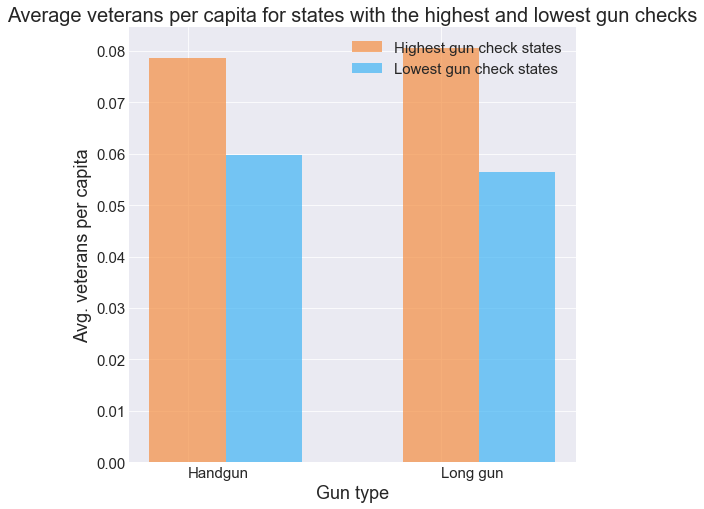

In [137]:
labels = ['Handgun', 'Long gun']

# Set means of 'Veterans' columns as heights
high_hg_height = high_hg_means['Mean'][8]
low_hg_height = low_hg_means['Mean'][8]
high_lg_height = high_lg_means['Mean'][8]
low_lg_height = low_lg_means['Mean'][8]

high_means = [high_hg_height, high_lg_height]
low_means = [low_hg_height, low_lg_height]
    
ind = np.arange(len(labels)) # the x locations for the groups
width = 0.3 # the width of the bars

plt.figure(figsize=(8, 8))  # width:20, height:5

# plot bars
high_bars = plt.bar(ind, high_means, width, color='#f48e41', alpha=.7, label='Highest gun check states')
low_bars = plt.bar(ind + width, low_means, width, color='#41b5f4', alpha=.7, label='Lowest gun check states')

# title and labels
plt.ylabel('Avg. veterans per capita', size=18)
plt.xlabel('Gun type', size=18)
plt.title('Average veterans per capita for states with the highest and lowest gun checks', size=20)
locations = ind + width / 2  # xtick locations
plt.xticks(ind, labels, size=15, ha='left')
plt.yticks(size=15)

# legend
plt.legend(loc=0, prop={'size': 15});

Now, I'll test for significance between these differences.

First, I'll get the p-value for the handgun data.

In [138]:
# test for significance
column = ['Veterans']
get_pvalues(column, high_handgun_census, low_handgun_census)

Veterans 0.05690871223773061


And then for the long gun data.

In [139]:
# test for significance
column = ['Veterans']
get_pvalues(column, high_longgun_census, low_longgun_census)

Veterans 0.0308763886349995


Based on the graph, the highest gun states have a higher average number of veterans per capita than the lowest gun states, for both handgun and long guns. However, this difference is only significant for long guns.

Now I'll move on to exploring the answers to my next question.

### Which states have had the largest changes in handgun checks and long gun checks between 2010 and 2016?

To answer this question, I need to pull the gun data and census population data for 2010. I already pulled the 2016 data above.

First I'll get the 2010 population from the census data so that I can normalize the 2010 gun data to population.

In [140]:
# convert the population columns from census_df into a list
pop_list_2010 = census_df['Population 2010'].tolist()

Now I'll pull the 2010 gun data.

In [141]:
# pull only the 2010 data from gun_df and group by state to get the sum
gun_2010_df = gun_df.loc[gun_df['year'] == '2010']
gun_totals_2010 = gun_2010_df.groupby('state').sum()

# reset index to convert groupby object back to dataframe
gun_totals_2010_df = gun_totals_2010.reset_index()
gun_totals_2010_df.head()

,state,handgun,long_gun
0,Alabama,116963.0,136519.0
1,Alaska,25720.0,33177.0
2,Arizona,89162.0,69067.0
3,Arkansas,49992.0,72206.0
4,California,245159.0,275458.0


Now I'm ready to normalize the values to population.

In [142]:
# list of columns that need normalized
gun_totals = ['handgun', 'long_gun']

# normalization function
normalize_to_pop(pop_list_2010, gun_totals_2010_df, gun_totals)      
        
# check to confirm
gun_totals_2010_df.head()

/Users/cadpav/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,state,handgun,long_gun
0,Alabama,0.024471,0.028562
1,Alaska,0.036214,0.046713
2,Arizona,0.013949,0.010805
3,Arkansas,0.017145,0.024763
4,California,0.006581,0.007394


Now that I have the hand gun and long gun data per capita for both 2010 and 2016, I'm ready to plot the changes for each state.

I'll first plot the changes for handgun checks.

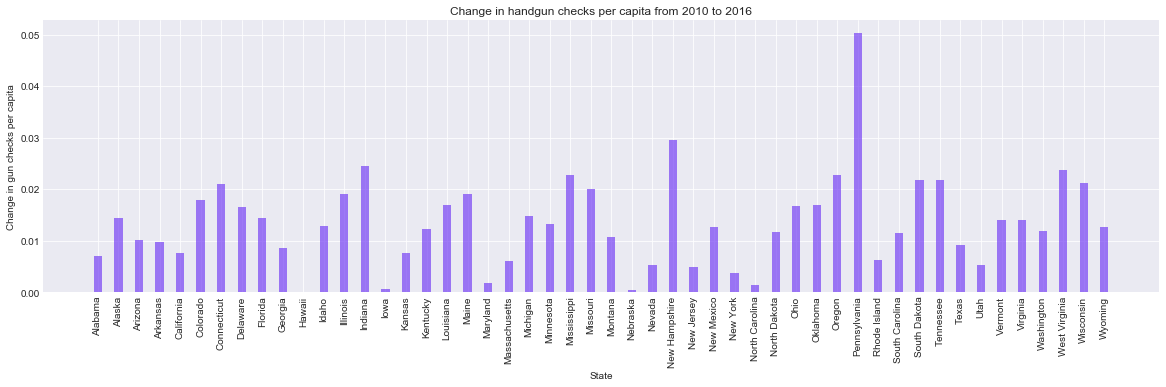

In [143]:
# plot change in handgun checks of all 50 states between 2010 and 2016

labels = gun_totals_2016_df['state'].tolist()
locations = range(1,51)

handgun_heights_2016 = gun_totals_2016_df['handgun'].tolist() 
handgun_heights_2010 = gun_totals_2010_df['handgun'].tolist()

# create list of change in gun sales
change_handgun_sales=[]
for a,b in zip(handgun_heights_2010,handgun_heights_2016):
    change_handgun_sales.append(b-a)

plt.figure(figsize=(20, 5))  # width:20, height:5
plt.bar(locations, change_handgun_sales, align='center', width=0.4, color='#7742f4', alpha=0.7)
plt.xticks(locations, labels, rotation='vertical' )

plt.title('Change in handgun checks per capita from 2010 to 2016')
plt.xlabel('State')
plt.ylabel('Change in gun checks per capita');


Pennsylvania had the greatest change in handgun checks per capita between 2010 and 2016, followed by New Hampshire. Iowa and Nebraska had the lowest change in handgun checks per capita.

Now I'll look at the change in long gun checks between 2010 and 2016.

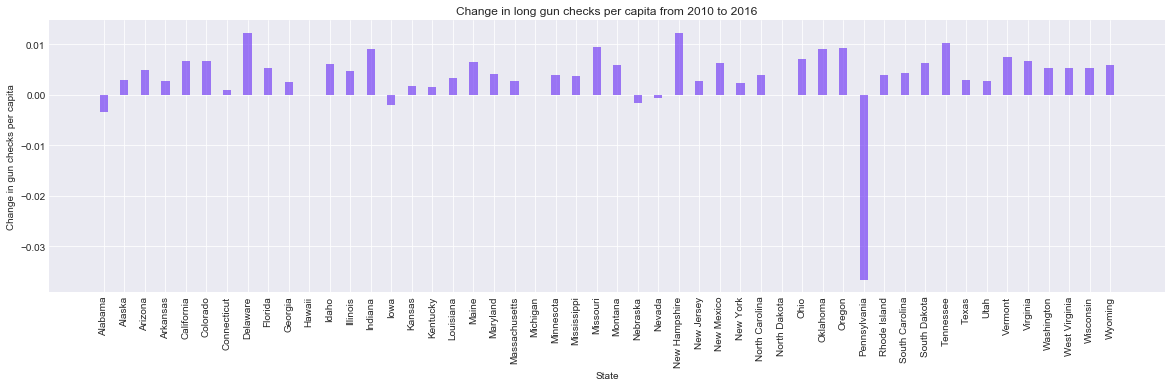

In [144]:
# plot change in long gun checks of all 50 states between 2010 and 2016

labels = gun_totals_2016_df['state'].tolist()
locations = range(1,51)

longgun_heights_2016 = gun_totals_2016_df['long_gun'].tolist() 
longgun_heights_2010 = gun_totals_2010_df['long_gun'].tolist()

# create list of change in gun sales
change_longgun_sales=[]
for a,b in zip(longgun_heights_2010,longgun_heights_2016):
    change_longgun_sales.append(b-a)

plt.figure(figsize=(20, 5))  # width:20, height:5
plt.bar(locations, change_longgun_sales, align='center', width=0.4, color='#7742f4', alpha=0.7)
plt.xticks(locations, labels, rotation='vertical' )

plt.title('Change in long gun checks per capita from 2010 to 2016')
plt.xlabel('State')
plt.ylabel('Change in gun checks per capita');


Connecticut and New Hampshire had the highest positive change in long gun checks per capita. Pennsylvania actually decreased in long gun checks, and had the largest change overall.

I'll now move on to explore the answers to my final question.

### What is the overall trend in U.S. handgun checks and long gun checks over the years?

To answer this question, I will first want to group gun data by year and get the means for each year. This is because I'm looking at the average number of gun checks of all the U.S. states combined and not per state this time.

In [145]:
# group gun data by year and look at means
means_by_year = gun_df.groupby('year').mean()

# set groupby object as dataframe
means_by_year = means_by_year.reset_index()

#confirm
means_by_year.head()


,year,handgun,long_gun
0,1998,2195.950000,5826.820000
1,1999,4220.851667,8693.866667
2,2000,3645.968333,7964.603333
3,2001,3601.943333,8236.636667
4,2002,3063.731667,7346.443333


In [146]:
# check end of dataset
means_by_year.tail()

,year,handgun,long_gun
15,2013,10620.631667,11875.830000
16,2014,10307.586667,9233.693333
17,2015,12197.800000,9127.480000
18,2016,13450.881667,9975.523333
19,2017,11624.620000,7597.982222


The gun dataset has data from 1998 to 2017, so this is the range of years I will analyze to look at the trend over time.

In [147]:
# get list of populations from 1998 to 2017 (to match with gun data)
shortened_population_df = population_df.iloc[1:21]
population_list = shortened_population_df['Population (millions)'].tolist()
population_list

[325.72,
 323.41,
 321.04,
 318.62,
 316.23,
 313.99,
 311.64,
 309.34,
 306.77,
 304.09,
 301.23,
 298.38,
 295.52,
 292.81,
 290.11,
 287.63,
 284.97,
 282.16,
 279.04,
 275.85]

This population list goes in the order from 2017 to 1998. I need to reverse this order so that it matches up with the gun data order.

In [148]:
# reverse population list and confirm
population_list = population_list[::-1]
population_list

[275.85,
 279.04,
 282.16,
 284.97,
 287.63,
 290.11,
 292.81,
 295.52,
 298.38,
 301.23,
 304.09,
 306.77,
 309.34,
 311.64,
 313.99,
 316.23,
 318.62,
 321.04,
 323.41,
 325.72]

Now I just need to divide means_by_year values for handguns and long guns by the population of the respective year in order to normalize the data.

In [149]:
# list of columns to normalize
columns = ['handgun', 'long_gun']

# normalization function
normalize_to_pop(population_list, means_by_year, columns)

# confirm
means_by_year.head()

/Users/cadpav/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,year,handgun,long_gun
0,1998,7.960667,21.123147
1,1999,15.126332,31.156346
2,2000,12.921634,28.227259
3,2001,12.639728,28.903522
4,2002,10.651642,25.541297


Now I'm ready to create a line plot to see the trend in gun checks per capita over the years.

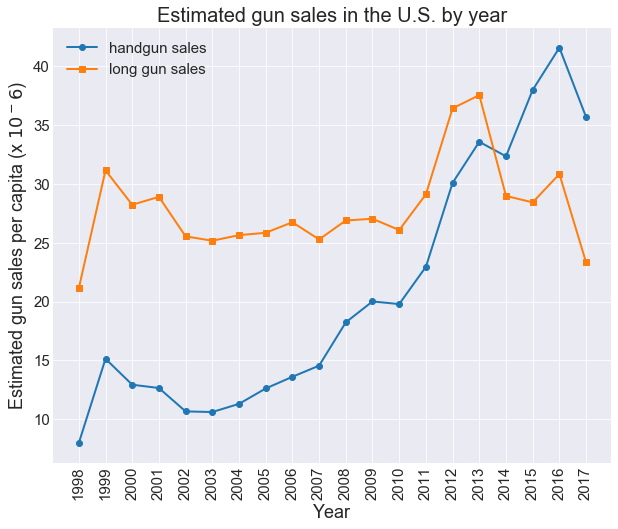

In [150]:
handgun_data = means_by_year['handgun'].tolist()
longgun_data = means_by_year['long_gun'].tolist()

years = means_by_year['year'].tolist()

fig = plt.figure(figsize=(10,8))

plt.plot(years, handgun_data, label='handgun sales', lw=2, marker='o')
plt.plot(years, longgun_data, label='long gun sales', lw=2, marker='s')
plt.title('Estimated gun sales in the U.S. by year', size=20)
plt.xlabel('Year', size=18)
plt.ylabel('Estimated gun sales per capita (x $10^-6$)', size=18)
plt.xticks(rotation='vertical', size=15)
plt.yticks(size=15)
plt.grid(True)
plt.legend(loc=0,prop={'size': 15});

Based on this graph, it looks like handgun sales have been trending upward in the U.S. overall, while long gun sales have remained relatively steady.

<a id='conclusions'></a>
## Conclusions


Based on this analysis, I can conclude that certain census demographics are more associated with states with a high number of gun checks per capita compared to those with a lower number. In particular, for hand gun checks, states with the top five highest number of checks in 2016 are associated with a lower percentage of the Hispanic/Latino demographic compared to the five lowest states. For long gun checks, there was a greater number of significant differences detected - states with the top five highest number of long gun checks in 2016 are associated with a lower percentage of the Black/African American demographic, a lower percentage of the Hispanic/Latino demographic, a higher percentage of the white demographic, lower population density, and a higher number of veterans per capita, compared to those of the five lowest states.

In addition, from this analysis I can conclude that between 2010 and 2016, all 50 states had a growth in the number of handgun checks, with Pennsylvania having the greatest growth during this time, followed by New Hampshire. Interestingly, for long gun checks Pennsylvania had the only *negative* change between 2010 and 2016 - and the greatest change overall. All of  the other states had a growth in the number of long gun checks, with New Hampshire and Connecticut having the highest growth.

Lastly, I can conclude that overall, there has been an upward trend in the number of background checks called in for handgun purchases in the U.S. based on data from 1998 to now. For long guns, despite a couple of spikes, the number of checks has remained relatively steady.

Because these background check numbers are the best proxy for total gun sales in a given time, these conclusions could also be applied to gun sale trends and demographics. However, since a one-to-one correlation cannot be made between a gun background check and a gun sale, and because private sales are not taken into account, I've expressed these conclusions in terms of background checks only.
